In [9]:
%run init_notebookspace.py
from settings import DATA_DIR, MODEL_DIR

DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\memoire1\data


In [10]:
import pandas as pd
import pandas_datareader.fred as fred
import numpy as np

from src.plotting import plot_dfs, all_equal
from src.process_data import get_fred_data, ser_adf, get_seasonal_hp, load_data
from src.classes import PolyDetrend
from src.utils import apply_func

import seaborn as sns

import datetime as dt

Load data

In [3]:
from config import fred_dict, recession_dict
df_all = load_data('raw_data.csv', DATA_DIR, fred_dict)

work data

In [4]:
df = df_all.copy()
df.drop(['recs', 'defl'], axis=1, inplace=True)

# sample period
print(f'sample starts: {df.index[0].date()} \nsample ends: {df.index[-1].date()}')

# check for missing intra sample data
pd.DataFrame(df.index - df.index.shift(-1)).describe()

sample starts: 1990-01-01 
sample ends: 2022-10-01


,date
count,132
mean,91 days 07:27:16.363636364
std,0 days 18:33:02.444181072
min,90 days 00:00:00
25%,91 days 00:00:00
50%,91 days 12:00:00
75%,92 days 00:00:00
max,92 days 00:00:00


#### log transform
We are log transforming because the final model will be log-linearized, as such it is describing log deviations in steady state. For the data to match these, logs need to be taken. This excludes all variables that are in percentages already, namely $\bf \pi$ and $r$.

In [5]:
log_cols = ["Y", "I", "C", "Ix", "Zx", "L", "w"]
for col in log_cols:
    df[col] = apply_func(arr=df[col], func=np.log)

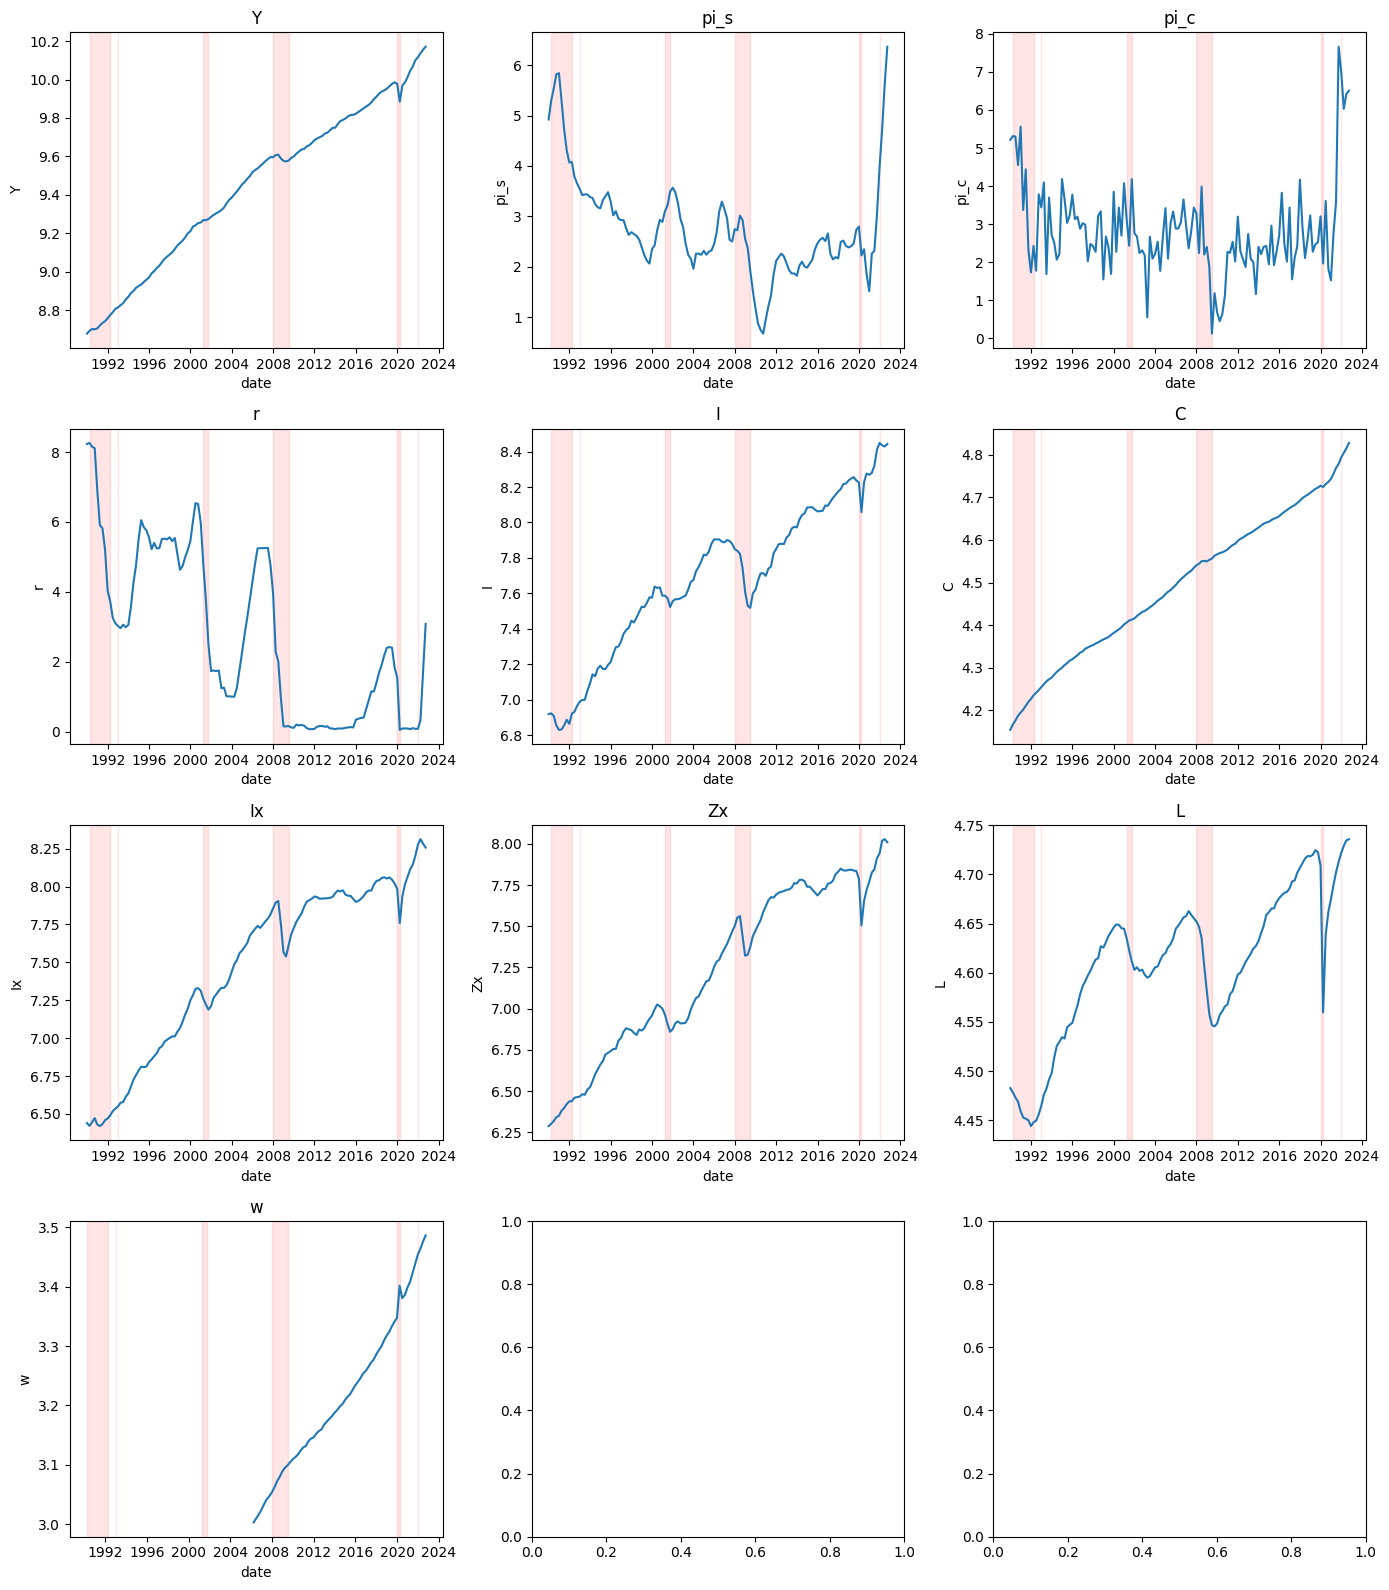

In [6]:
plot_dfs(df, sns.lineplot, fill_arr=recession_dict)

#### train test split

In [28]:
test_size = .2
test_ind = df.iloc[-round(len(df) * test_size):,:].index
train_ind = df.iloc[:-round(len(df) * test_size),:].index

In [29]:
print(f'test size is: {test_size * 100}%, corresponding to {len(test_ind)} lines')
print(f'time between train & test: {(test_ind[0] - train_ind[-1])}')

test size is: 20.0%, corresponding to 26 lines
time between train & test: 91 days 00:00:00


#### HP filter detrend
The HP filter seperates long-term trend (steady-state) GDP from cycle fluctuations. It outputs decimal percentages, wherefore data that is in percentage terms already needs transformation into decimal percentages.

In [45]:
df_2 = df.copy()

In [47]:
from statsmodels.tsa.filters.hp_filter import hpfilter

# hp detrend
detrend_cols = ["Y", "I", "C", "L", "Ix", "Zx", "w"]
for col in detrend_cols:
    df_2[f'{col}_cycle'] = df[col].copy()
    ser = df_2.w.dropna().copy()
    
    cycle, trend = hpfilter(ser, lamb=1600)
    df_2[col].loc[ser.index] = trend
    df_2[f'{col}_cycle'].loc[ser.index] = cycle

In [48]:
# pi should be decimal percentage, this what log hp filter outputs
# why log - johann pfeifer estimation of structural models ...

In [49]:
dperc_cols = ["pi_s", "pi_c", "r"]
df_2[dperc_cols] = df_2[dperc_cols] / 100

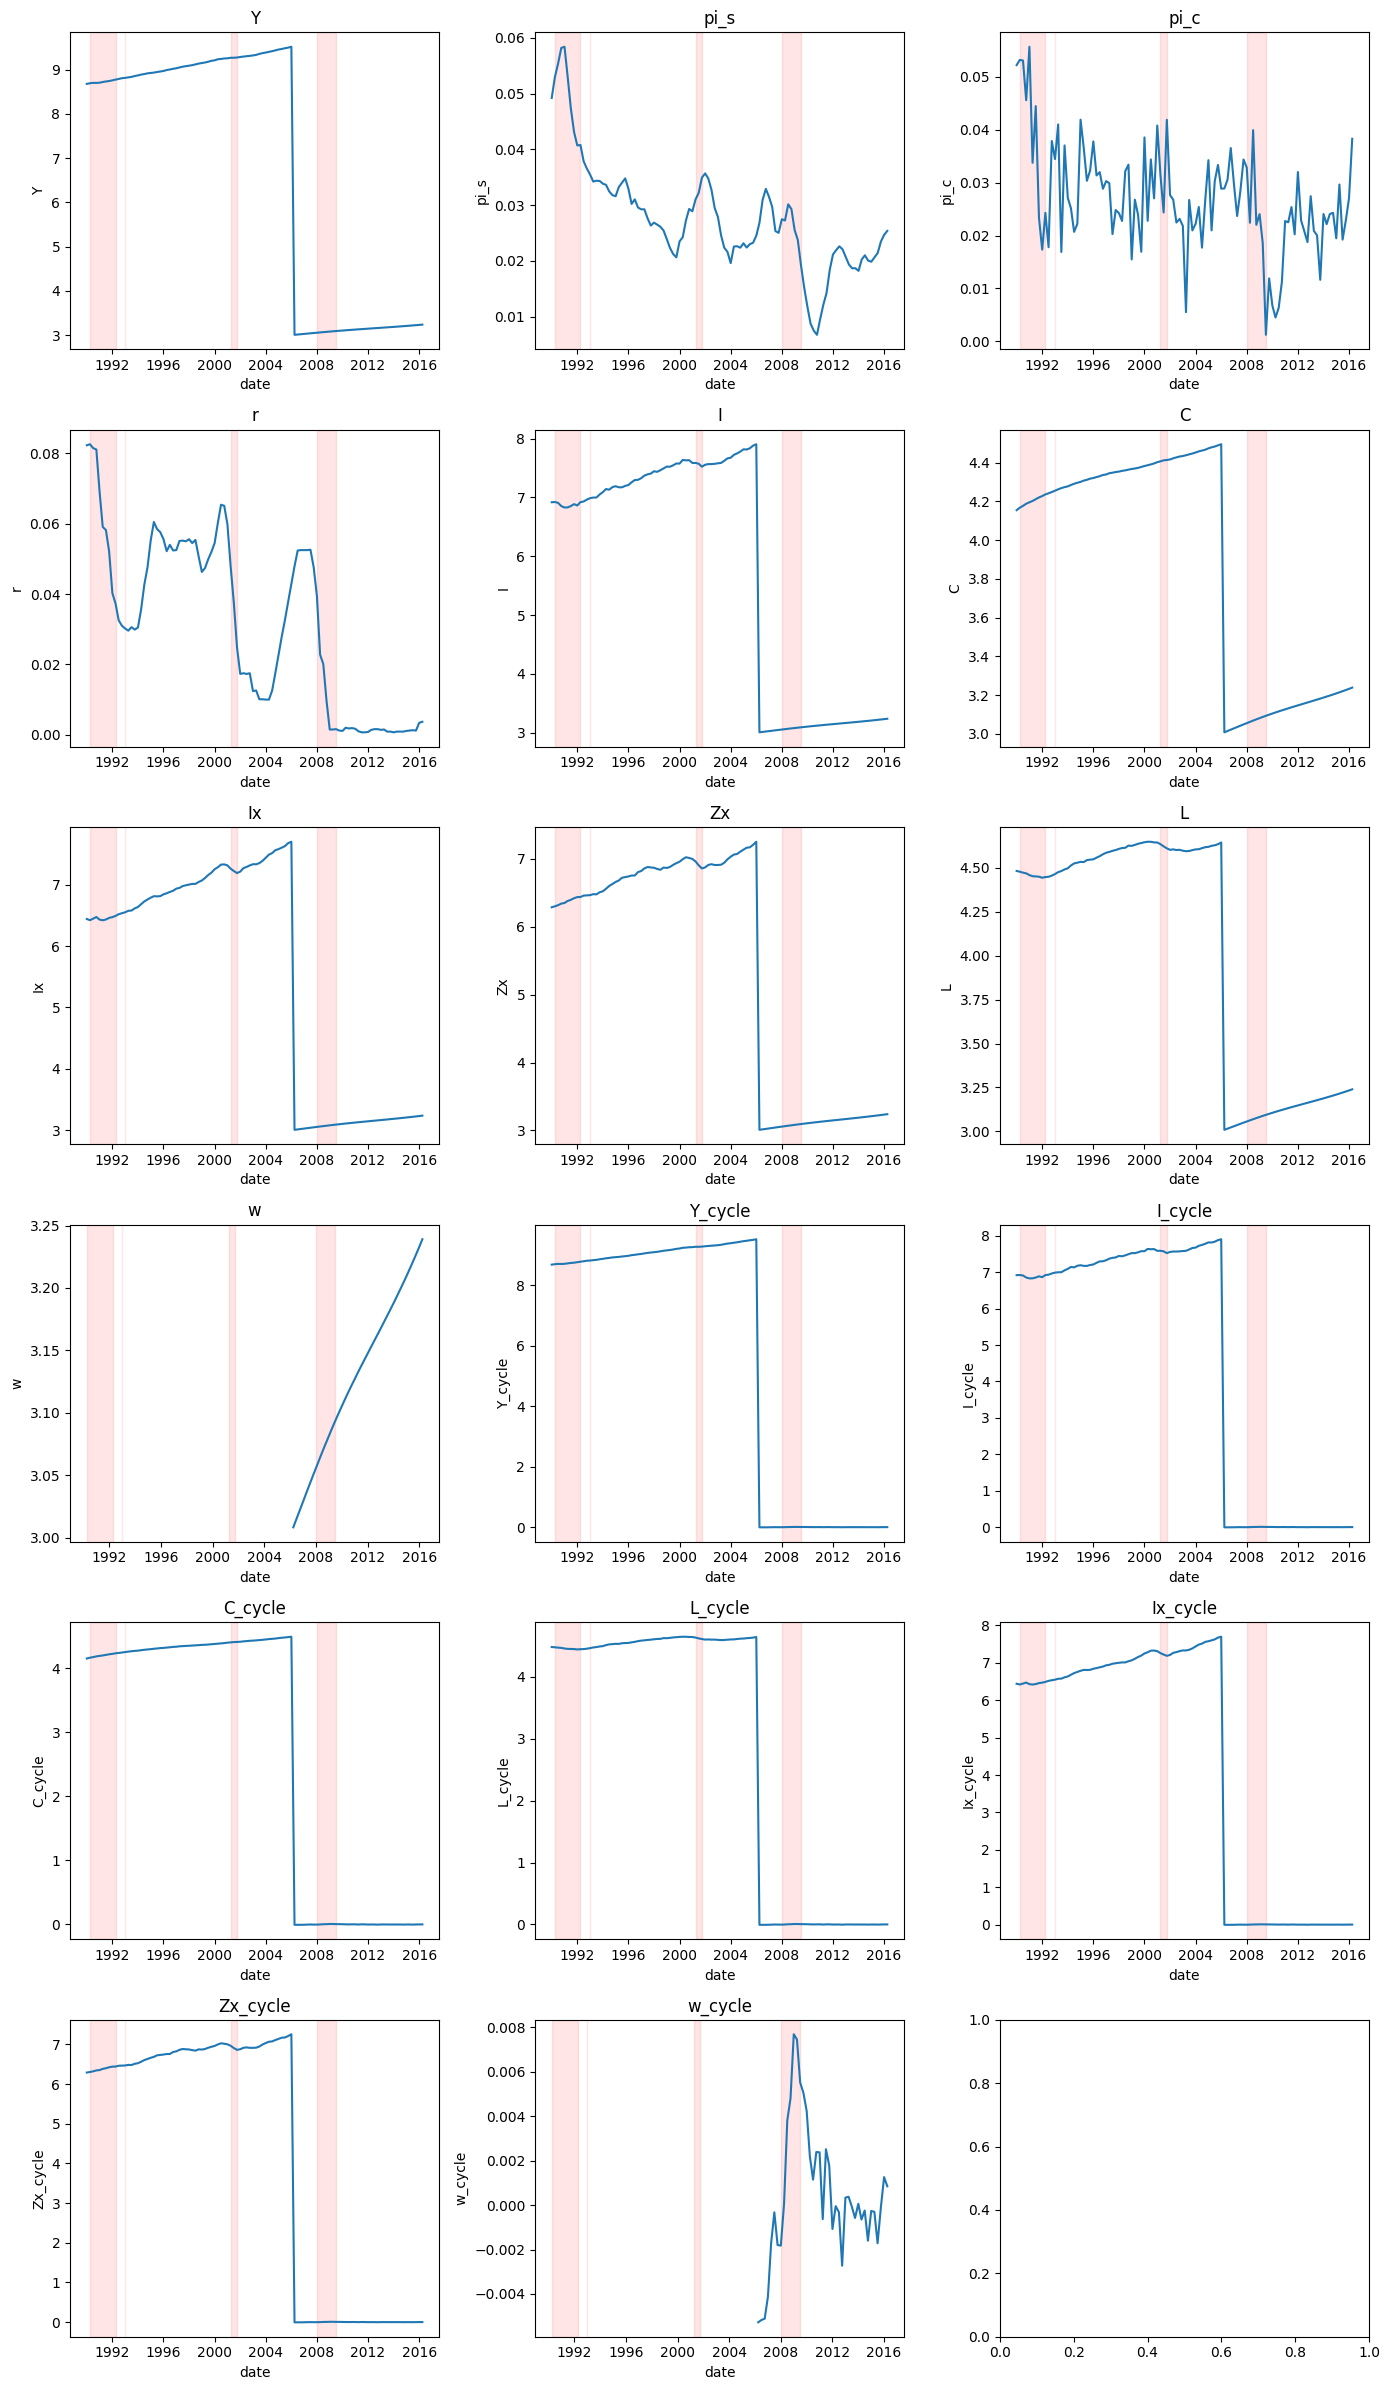

In [50]:
# plot cycle
plot_dfs(df_2.loc[train_ind], sns.lineplot, fill_arr=recession_dict)

stationarity

In [15]:
# train data hp filter
for col in df_2.columns:
    ser_adf(df_2.loc[train_ind, col])

Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- Y --------------------
 p-val: 0.7965572442407225,  reject: False


Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- pi_s --------------------
 p-val: 0.08401652335468218,  reject: False


Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- pi_c --------------------
 p-val: 0.0012257990149456583,  reject: True


Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- r --------------------
 p-val: 0.08974787376317989,  reject: False


Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- I --------------------
 p-val: 0.7745407920644537,  reject: False


Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- C --------------------
 p-val: 0.7336778048497592,  reject: False


Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- Ix --------------------
 p-val: 0.7577893028590901,  reject: False


Augmented Dickey-Fuller Test: H0 -> unit roo

In [16]:
# using the HP filter due to better enforcement of statiornarity

save data

In [18]:
df_2[[item for item in df_2.columns if "cycle" not in item]]

['Y', 'pi_s', 'pi_c', 'r', 'I', 'C', 'Ix', 'Zx', 'L', 'w']

In [ ]:
df_2['is_test'] = list([False] * len(df_2))
df_2.loc[test_ind, 'is_test'] = list([True] * len(test_ind))

In [ ]:
df_2.reset_index(names='date').to_csv(os.path.join(DATA_DIR, 'prepro_data.csv'))